In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 적층 오토인코더(stacked autoencoder)

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [4]:
X_train.shape, y_train.shape

((55000, 28, 28), (55000,))

2600X + 1080에서 한 에포크에 24-26초

950M에선 시작하는 데 약 4-5분이 걸렸지만 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), #784
    keras.layers.Dense(100, activation="selu"), #100
    keras.layers.Dense(30, activation="selu")   #30 - 코딩층을 기점으로 대칭
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]), #100
    keras.layers.Dense(28 * 28, activation="sigmoid"),            #784
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([
    stacked_encoder,
    stacked_decoder
])

stacked_ae.compile(loss="binary_crossentropy", #재구성시 픽셀이 검정인지 휜색인지 분류(0인지 255인지) - 더 빠르다
                  optimizer=keras.optimizers.SGD(learning_rate=1.5),
                  metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,       #오토 인코더는 입력과 동일한 출력을 내도록 훈련하므로! 입력과 타겟이 같다!!!
                        validation_data=(X_valid, X_valid)) #마찬가지!

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
36384/55000 [==================>...........] - ETA: 13s - loss: 0.3515 - rounded_accuracy: 0.8751

In [11]:
#예측과 생성해낸 재구성을 비교

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [13]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

Saving figure reconstruction_plot


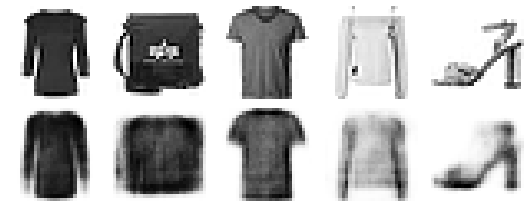

In [14]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

### 패션 mnist 데이터셋 시각화

적층 오토인코더의 인코더 모델을 사용해 차원을 30으로 줄이고 t-SNE로 2차원 까지 줄임

In [20]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2d = tsne.fit_transform(X_valid_compressed)
X_valid_2d = (X_valid_2d - X_valid_2d.min()) / (X_valid_2d.max() - X_valid_2d.min())

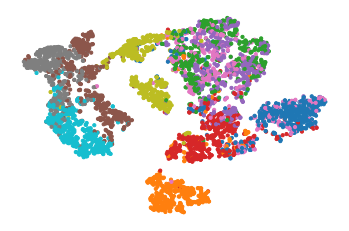

In [21]:
plt.scatter(X_valid_2d[:, 0], X_valid_2d[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Saving figure fashion_mnist_visualization_plot


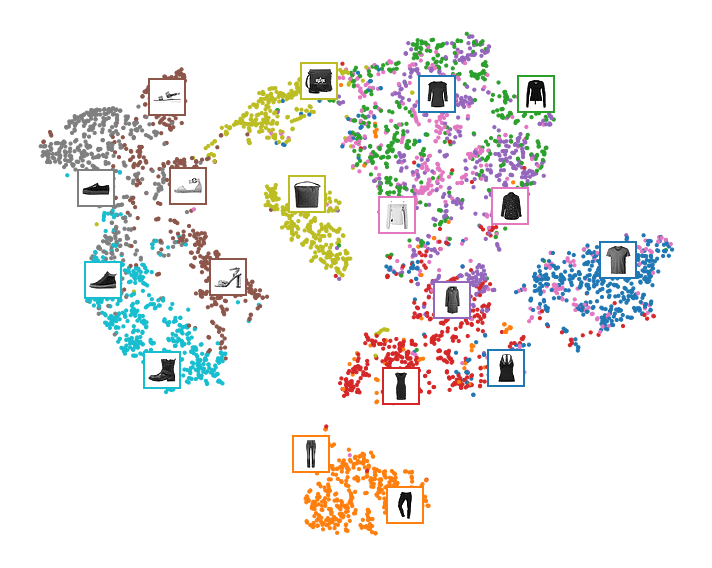

In [22]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2d[:, 0], X_valid_2d[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

### 적층 오토인코더를 사용한 비지도 사전훈련

레이블이 훈련된 데이터가 많지 않은 복잡한 지도 학습 문제 

먼저 전체 데이터를 사용해 적층 오토인코더를 훈련 -> 하위층을 재사용해 실제 레이블된 데이터를 사용해 훈련

### 가중치 묶기

오토 인코더가 완벽하게 대칭일 때는 디코더의 가중치와 인코더의 가중치를 묶어서 모델의 가중치 수를 절반으로 줄여 훈련 속도를 높이고 과대적합의 위험을 줄인다

In [24]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 24s 442us/sample - loss: 0.3268 - rounded_accuracy: 0.8960 - val_loss: 0.3024 - val_rounded_accuracy: 0.9208
Epoch 2/10
55000/55000 [==============================] - 25s 446us/sample - loss: 0.2974 - rounded_accuracy: 0.9225 - val_loss: 0.2974 - val_rounded_accuracy: 0.9271
Epoch 3/10
55000/55000 [==============================] - 25s 455us/sample - loss: 0.2918 - rounded_accuracy: 0.9277 - val_loss: 0.2962 - val_rounded_accuracy: 0.9264
Epoch 4/10
55000/55000 [==============================] - 25s 448us/sample - loss: 0.2889 - rounded_accuracy: 0.9303 - val_loss: 0.2899 - val_rounded_accuracy: 0.9322
Epoch 5/10
55000/55000 [==============================] - 23s 415us/sample - loss: 0.2867 - rounded_accuracy: 0.9322 - val_loss: 0.2867 - val_rounded_accuracy: 0.9338
Epoch 6/10
55000/55000 [==============================] - 24s 430us/sample - loss: 0.2851 - rounded_accuracy: 0.9338

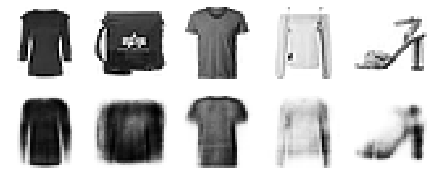

In [26]:
show_reconstructions(tied_ae)
plt.show()

# 합성곱 오토 인코더

이미지를 다룰 대는 합성곱 네트워크가 밀집 네트워크보다 잘 맞는다

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([ #입력의 높이와 너비를 줄이고 깊이(특성맵의 개수)를 늘린다.
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([ #반대로 이미지의 스케일을 늘리고, 깊이를 원본 차원으로 돌린다
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 42s 767us/sample - loss: 0.3018 - rounded_accuracy: 0.9184 - val_loss: 0.2799 - val_rounded_accuracy: 0.9388
Epoch 2/5
55000/55000 [==============================] - 40s 728us/sample - loss: 0.2755 - rounded_accuracy: 0.9413 - val_loss: 0.2758 - val_rounded_accuracy: 0.9433
Epoch 3/5
55000/55000 [==============================] - 40s 723us/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2725 - val_rounded_accuracy: 0.9455
Epoch 4/5
55000/55000 [==============================] - 40s 729us/sample - loss: 0.2681 - rounded_accuracy: 0.9490 - val_loss: 0.2677 - val_rounded_accuracy: 0.9513
Epoch 5/5
55000/55000 [==============================] - 38s 693us/sample - loss: 0.2663 - rounded_accuracy: 0.9508 - val_loss: 0.2666 - val_rounded_accuracy: 0.9523


In [28]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

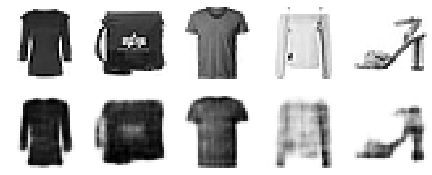

In [29]:
show_reconstructions(conv_ae)
plt.show()

# 잡음 제거 오토인코더

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),              #인코더의 입력에 가우시안노이즈 혹은 드롭아웃
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 26s 472us/sample - loss: 0.3513 - rounded_accuracy: 0.8763 - val_loss: 0.3179 - val_rounded_accuracy: 0.9066
Epoch 2/10
55000/55000 [==============================] - 26s 478us/sample - loss: 0.3126 - rounded_accuracy: 0.9093 - val_loss: 0.3079 - val_rounded_accuracy: 0.9165
Epoch 3/10
55000/55000 [==============================] - 26s 478us/sample - loss: 0.3058 - rounded_accuracy: 0.9150 - val_loss: 0.3030 - val_rounded_accuracy: 0.9191
Epoch 4/10
55000/55000 [==============================] - 25s 459us/sample - loss: 0.3021 - rounded_accuracy: 0.9183 - val_loss: 0.2999 - val_rounded_accuracy: 0.9232
Epoch 5/10
55000/55000 [==============================] - 24s 431us/sample - loss: 0.2991 - rounded_accuracy: 0.9209 - val_loss: 0.2969 - val_rounded_accuracy: 0.9253
Epoch 6/10
55000/55000 [==============================] - 24s 440us/sample - loss: 0.2968 - rounded_accuracy: 0.9230

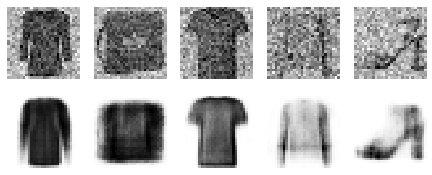

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [32]:
# 드롭아웃 사용

tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 28s 509us/sample - loss: 0.3572 - rounded_accuracy: 0.8703 - val_loss: 0.3193 - val_rounded_accuracy: 0.9052
Epoch 2/10
55000/55000 [==============================] - 27s 489us/sample - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3117 - val_rounded_accuracy: 0.9115
Epoch 3/10
55000/55000 [==============================] - 26s 474us/sample - loss: 0.3128 - rounded_accuracy: 0.9076 - val_loss: 0.3087 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 26s 470us/sample - loss: 0.3096 - rounded_accuracy: 0.9100 - val_loss: 0.3048 - val_rounded_accuracy: 0.9164
Epoch 5/10
55000/55000 [==============================] - 26s 466us/sample - loss: 0.3070 - rounded_accuracy: 0.9120 - val_loss: 0.3023 - val_rounded_accuracy: 0.9178
Epoch 6/10
55000/55000 [==============================] - 26s 466us/sample - loss: 0.3052 - rounded_accuracy: 0.9134

Saving figure dropout_denoising_plot


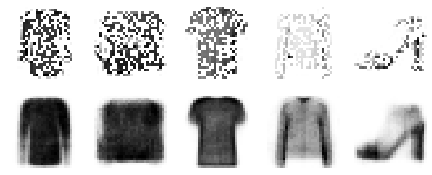

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# 희소 오코인코더(sparse)

코딩 층에서 활성화되는 뉴런 수를 감소시켜서 꼭 필요한 특성을 표현하도록 함(한달에 몇 마디 말만 할 수 있다면 꼭 필요한 말만 할 것)

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),  #코딩 층에 시그모이드 사용(코딩을 0과 1사이 값으로 제한)
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 26s 471us/sample - loss: 0.4332 - rounded_accuracy: 0.7944 - val_loss: 0.3777 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 25s 460us/sample - loss: 0.3614 - rounded_accuracy: 0.8667 - val_loss: 0.3511 - val_rounded_accuracy: 0.8785
Epoch 3/10
55000/55000 [==============================] - 25s 462us/sample - loss: 0.3403 - rounded_accuracy: 0.8860 - val_loss: 0.3360 - val_rounded_accuracy: 0.8898
Epoch 4/10
55000/55000 [==============================] - 25s 456us/sample - loss: 0.3280 - rounded_accuracy: 0.8962 - val_loss: 0.3256 - val_rounded_accuracy: 0.9006
Epoch 5/10
55000/55000 [==============================] - 25s 461us/sample - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3215 - val_rounded_accuracy: 0.9018
Epoch 6/10
55000/55000 [==============================] - 25s 451us/sample - loss: 0.3178 - rounded_accuracy: 0.9037

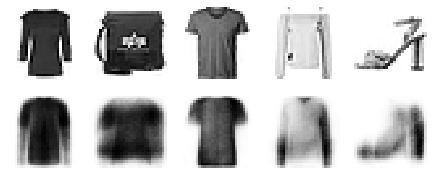

In [35]:
show_reconstructions(simple_ae)
plt.show()

In [36]:
#활성화 히스토그램

def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [37]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

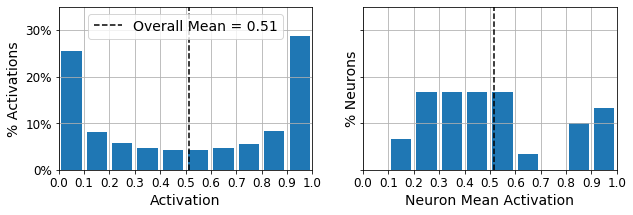

In [39]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

왼쪽은 모든 활성화의 분포
오른쪽은 뉴런의 평균 활성화 분포 - 뉴런 대부분의 활성화가 0.5에 가깝다.

그러니까 각 뉴런은 0이나 1에 가까우면 활성화 되는데

일부 뉴런은 항상 활성화 된다.

In [40]:
#코딩 층에 l1 규체 추가

tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 29s 529us/sample - loss: 0.4311 - rounded_accuracy: 0.8128 - val_loss: 0.3809 - val_rounded_accuracy: 0.8564
Epoch 2/10
55000/55000 [==============================] - 28s 515us/sample - loss: 0.3691 - rounded_accuracy: 0.8687 - val_loss: 0.3639 - val_rounded_accuracy: 0.8750
Epoch 3/10
55000/55000 [==============================] - 27s 486us/sample - loss: 0.3546 - rounded_accuracy: 0.8799 - val_loss: 0.3504 - val_rounded_accuracy: 0.8859
Epoch 4/10
55000/55000 [==============================] - 27s 499us/sample - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3437 - val_rounded_accuracy: 0.8917
Epoch 5/10
55000/55000 [==============================] - 28s 512us/sample - loss: 0.3373 - rounded_accuracy: 0.8922 - val_loss: 0.3361 - val_rounded_accuracy: 0.8946
Epoch 6/10
55000/55000 [==============================] - 28s 504us/sample - loss: 0.3319 - rounded_accuracy: 0.8971

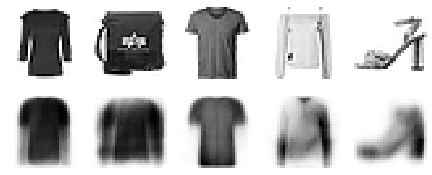

In [41]:
show_reconstructions(sparse_l1_ae)

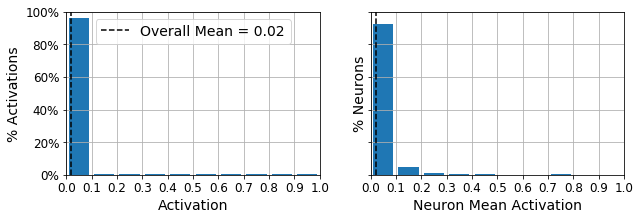

In [42]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

In [43]:
# KL 발산 규제

K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 38s 690us/sample - loss: 0.4152 - rounded_accuracy: 0.8119 - val_loss: 0.3717 - val_rounded_accuracy: 0.8562
Epoch 2/10
55000/55000 [==============================] - 38s 687us/sample - loss: 0.3534 - rounded_accuracy: 0.8759 - val_loss: 0.3445 - val_rounded_accuracy: 0.8849
Epoch 3/10
55000/55000 [==============================] - 38s 691us/sample - loss: 0.3342 - rounded_accuracy: 0.8917 - val_loss: 0.3295 - val_rounded_accuracy: 0.8976
Epoch 4/10
55000/55000 [==============================] - 38s 699us/sample - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3214 - val_rounded_accuracy: 0.9037
Epoch 5/10
55000/55000 [==============================] - 38s 690us/sample - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9082
Epoch 6/10
55000/55000 [==============================] - 37s 678us/sample - loss: 0.3134 - rounded_accuracy: 0.9093

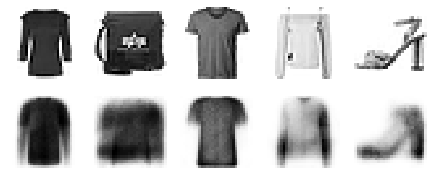

In [45]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


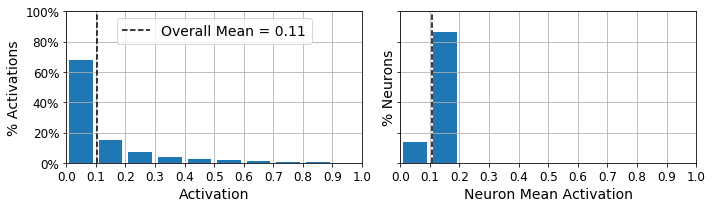

In [46]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# 변이형 오코인코더

확률적이다 - 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정된다.
생성 오코인코더 - 새로운 샘플 생성 가능

RBM과 유사

In [47]:
#샘플링 사용자 정의 층

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [48]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 17s 312us/sample - loss: 0.3897 - rounded_accuracy: 0.8597 - val_loss: 0.3499 - val_rounded_accuracy: 0.8953
Epoch 2/25
55000/55000 [==============================] - 16s 285us/sample - loss: 0.3432 - rounded_accuracy: 0.8972 - val_loss: 0.3357 - val_rounded_accuracy: 0.9056
Epoch 3/25
55000/55000 [==============================] - 16s 293us/sample - loss: 0.3329 - rounded_accuracy: 0.9049 - val_loss: 0.3327 - val_rounded_accuracy: 0.9082
Epoch 4/25
55000/55000 [==============================] - 16s 296us/sample - loss: 0.3278 - rounded_accuracy: 0.9091 - val_loss: 0.3287 - val_rounded_accuracy: 0.9081
Epoch 5/25
55000/55000 [==============================] - 16s 291us/sample - loss: 0.3247 - rounded_accuracy: 0.9114 - val_loss: 0.3263 - val_rounded_accuracy: 0.9081
Epoch 6/25
55000/55000 [==============================] - 16s 287us/sample - loss: 0.3224 - rounded_accuracy: 0.9134

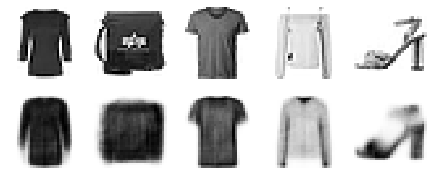

In [49]:
show_reconstructions(variational_ae)
plt.show()

### 패션 이미지 생성하기ㅡ

In [50]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Saving figure vae_generated_images_plot


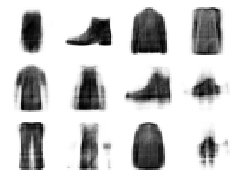

In [51]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

Saving figure semantic_interpolation_plot


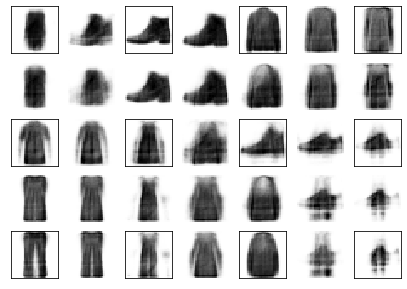

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# 테두리가 있는 것들은 원본 이미지
# 나머지는 근방의 이미지를 시맨틱 보간

# 생성적 적대 신경망(Generative Adversarial Networks)

생성자는 위조품을 만들고, 판별자는 위조품을 걸러내고 둘이 경쟁하면서 훈련

생성자는 오토인코더의 디코더와 유사

판별자는 일반적인 이진 분류기

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [54]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False                              #판별자는 훈련하면 안된다.
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [55]:
#이미지를 순회하는 Dataset 생성

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [56]:
#훈련이 일반적인 반복이 아니므로 사용자 정의 훈련 반복 생성

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)                        #가우시안 잡음을 생성자에 주입(가짜 이미지 생성)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) #동일한 개수의 진짜 이미지 합쳐서 배치 생성
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) #가짜 이미지의 경우0, 진짜는 1
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False        #생성자를 훈련할 대는 판별자 훈련 금지
            gan.train_on_batch(noise, y2)           #GAN에 가우시안 잡음 주입. 생성자가 이미지를 생성하고, 판별자가 판별.(타겟은 y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/1


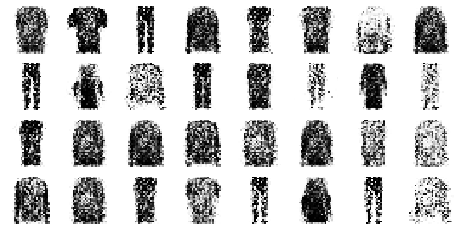

In [57]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

# 심층 합성곱 GAN

In [ ]:
X_train.shape

In [58]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [59]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [60]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [61]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10


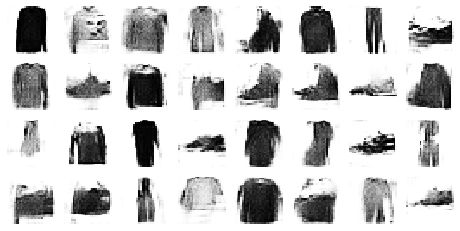

Epoch 2/10


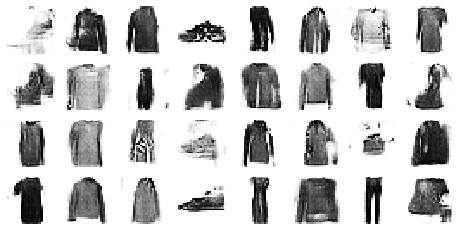

Epoch 3/10


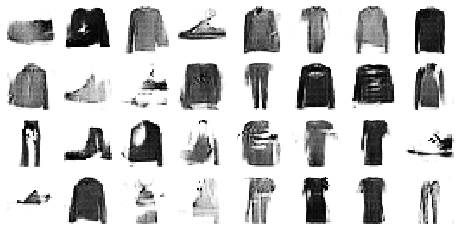

Epoch 4/10


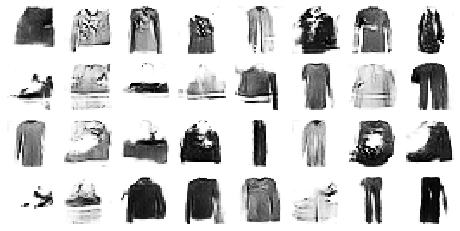

Epoch 5/10


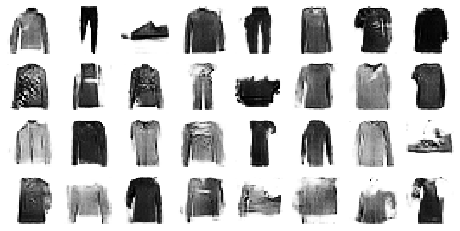

Epoch 6/10


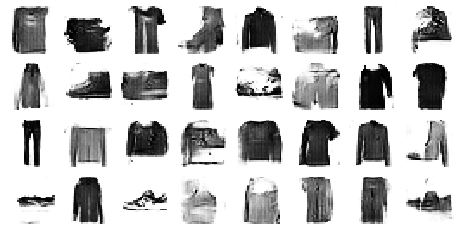

Epoch 7/10


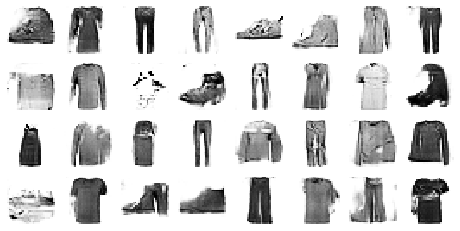

Epoch 8/10


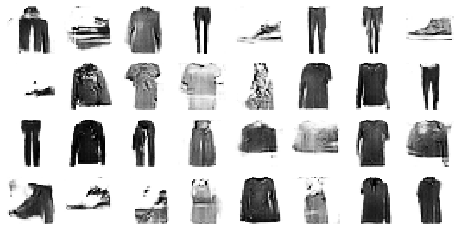

Epoch 9/10


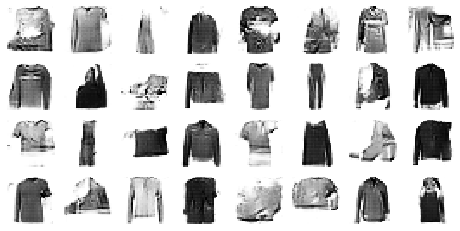

Epoch 10/10


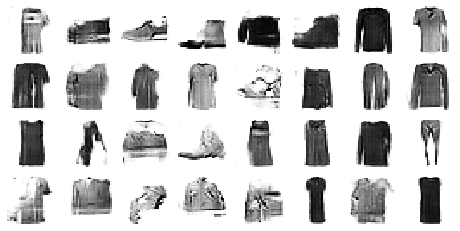

In [62]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

Saving figure dcgan_generated_images_plot


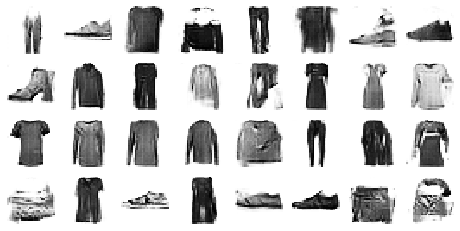

In [63]:
#에포크 10동안 훈련하여 생성해낸 이미지

tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

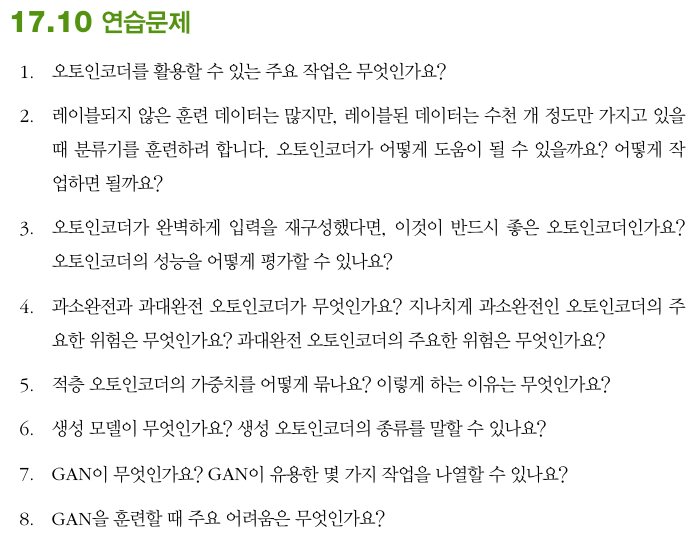

1. 특성 추출, 비지도 사전훈련, 차원 축소, 생성 모델, 이상치 탐지


2. 전체 데이터셋에 오토인코더를 훈련시키고, 하위층 절반(코딩층과 그 하위 층)을 재사용  
   레이블 데이터가 적다면 분류기를 훈련할 때 재사용된 층을 동결하는 것이 좋다
   
   
3. 꼭 그렇지는 않고 과대적합 가능성 있음  


4. 과소완전 오토인코더는 코딩 층이 입력층과 출력층보다 작은 경우. 코딩층이 더 크다면 과대완전  
   지나치케 과소완전의 경우 입력 재구성 실패 가능성 높음  
   과대완전의 경우 유용한 특성을 학습하지 못하고 입력을 그냥 출력으로 복사
   
   
5. 인코더 층의 가중치를 그에 상응하는 디코더 층와 묶음  
   모델의 파라미터 개수가 반으로 줄어 훈련 속도가 빨라지고 훈련 세트에 과대적합될 위험 감소
   
   
6. 생성 모델은 훈련 샘플과 닮은 출력을 랜덤하게 생성할 수 있는 모델  
   변이형 오토인코더
   
   
7. 생성적 적대 신경망. 생성자는 판별자를 속일 수 있는 샘플을 생성하고, 판별자는 가짜 샘플을 판별하면서 서로 경쟁적으로 학습  
   이미지 해상도 높이기, 이미지 편집, 동영상의 다음 프레임 예측 등의 고급 이미지 처리작업에 GAN 사용
   
   
8. 생성자와 판별자 사이의 복잡한 관계  
   생성자가 다양하지 않은 출력을 만드는 모드 붕괴 문제

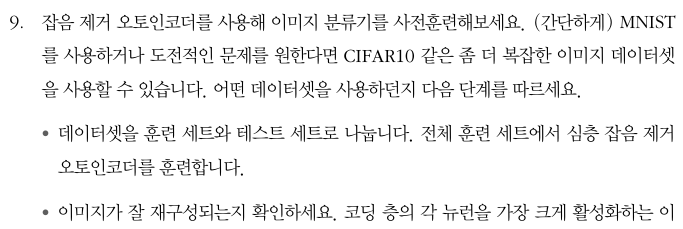
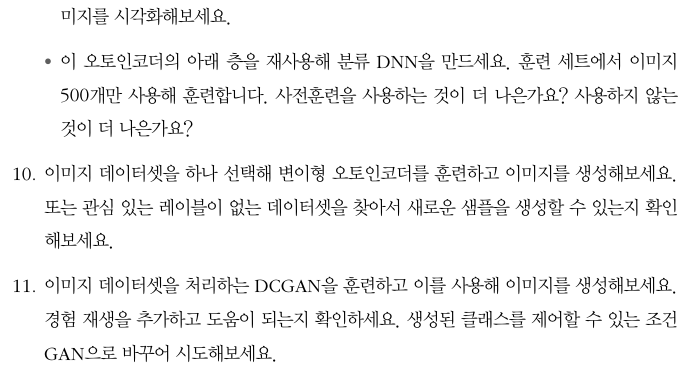